In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [86]:
np.pi

3.141592653589793

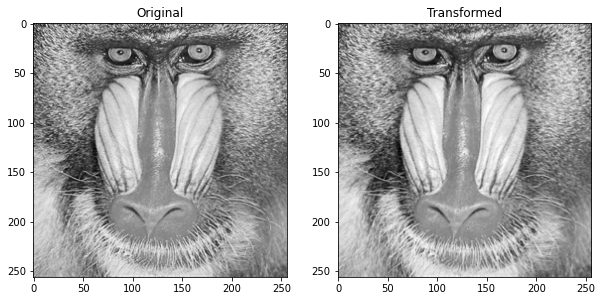

In [87]:
img_src = cv2.imread("Mandrill.bmp", 0).astype(np.float32) / 255.0

w = img_src.shape[1]
h = img_src.shape[0]
cx = (w - 1) / 2
cy = (h - 1) / 2
trans = [0.02, 0.04]
rot   = 0.001
scale = 1.002

mat = cv2.getRotationMatrix2D((cx, cy), np.rad2deg(rot), scale)
mat[0, 2] += trans[0]
mat[1, 2] += trans[1]
img_dst = cv2.warpAffine(img_src, mat, img_src.shape, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Original")
plt.imshow(img_src, "gray")
plt.subplot(122)
plt.title("Transformed")
plt.imshow(img_dst, "gray")

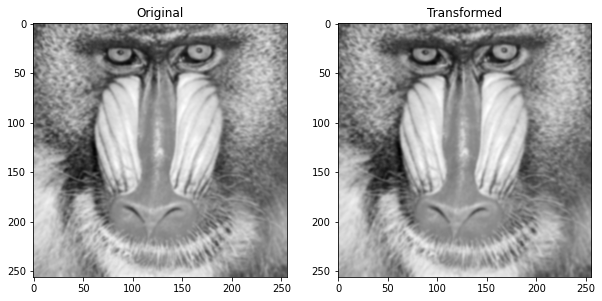

In [88]:
sigma = 1.0
img0 = cv2.GaussianBlur(img_src, (0, 0), sigma)
img1 = cv2.GaussianBlur(img_dst, (0, 0), sigma)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Original")
plt.imshow(img0, "gray")
plt.subplot(122)
plt.title("Transformed")
plt.imshow(img1, "gray")

In [99]:
def calc_grad(img):
    '''勾配計算'''

    # Sobleフィルタ
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    
    # Sobelフィルタの係数総和の8で割って傾きを正規化
    grad_x /= 8
    grad_y /= 8
    return grad_x, grad_y

gx0, gy0 = calc_grad(img0)
gx1, gy1 = calc_grad(img1)

# 移動量推定
diff  = img1 - img0
gx = (gx0 + gx1) / 2
gy = (gy0 + gy1) / 2

gx2 = np.sum(gx**2)
gxy = np.sum(gx*gy)
gy2 = np.sum(gy**2)
e0  = np.sum(diff*gx)
e1  = np.sum(diff*gy)

G = np.array([[gx2, gxy], [gxy, gy2]])
E = np.array([e0, e1])
D = np.linalg.solve(G, E)

dx = D[0]
dy = D[1]
#print("dx, dy = ", dx, dy)


# 回転量推定
x, y = np.meshgrid(np.arange(w)-cx, np.arange(h)-cy)
a = np.sum((-gx*y + gy*x)**2)
b = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
c = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
d = np.sum((gx*x + gy*y)**2)
e0 = np.sum(diff * (-gx*y + gy*x))
e1 = np.sum(diff * ( gx*x + gy*y))

G = np.array([[a, b], [c, d]])
E = np.array([e0, e1])
D = np.linalg.solve(G, E)

dt = D[0]
ds = 1.0-D[1]
#print("dt, ds = ", dt, ds)

# 結果表示
print(f"x     : {dx:0.5f} (err: {dx-trans[0]:0.5f})")
print(f"y     : {dy:0.5f} (err: {dx-trans[1]:0.5f})")
print(f"rot   : {dt:0.5f} (err: {dt-rot:0.5f})")
print(f"scale : {dt:0.5f} (err: {ds-scale:0.5f})")



x     : 0.0186 (err: -0.0014)
y     : 0.0169 (err: -0.0214)
rot   : 0.0011 (err: 0.0001)
scale : 0.0011 (err: 0.0001)
